# Data Exploration - Reviews
Exploration notebook for the reviews dataset, and for the combined reviews-restaurants dataset.

## 1. Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import regex as re
import nltk
import statistics
import random
import sys
import os

#Preprocessing
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
import pipeline as p
from pipeline import MainPipeline
import preproc as pp
import visualizations as v
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from textblob import TextBlob
sent_tokenizer = PunktSentenceTokenizer()
from collections import Counter

#Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Classification and Metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from tqdm import tqdm

In [2]:
reviews = pd.read_csv('../data_hyderabad/10k_reviews.csv')
restaurants = pd.read_csv('../data_hyderabad/105_restaurants.csv')
display(reviews.sample(5))
display(restaurants.sample(5))

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
3897,The Glass Onion,Shashank Karukonda,"The service is shit, the waiter asked us not a...",1,"2 Reviews , 2 Followers",3/5/2019 23:35,0
5155,Hitech Bawarchi Food Zone,Sravan,good delivery,4,"2 Reviews , 1 Follower",9/13/2018 14:03,0
7639,The Old Madras Baking Company,BOBBY REDDY PALLE,Beautiful set up with inside seating as well a...,5,"72 Reviews , 42 Followers",11/19/2018 14:51,2
8334,GD's,Shreyoshi Mandal,Got a Galaxy burger home delivered from this p...,4,"155 Reviews , 1803 Followers",11/11/2018 11:39,1
9850,Triptify,Shreyoshi Mandal,Got Cheese Combo Parathas home delivered for l...,4,"155 Reviews , 1803 Followers",8/26/2018 16:28,1


,Name,Links,Cost,Collections,Cuisines,Timings
39,Deli 9 Bistro,https://www.zomato.com/hyderabad/deli-9-bistro...,700,NaN,"Cafe, Continental, Desserts",12 Noon to 10:30 PM
58,Tempteys,https://www.zomato.com/hyderabad/tempteys-gach...,350,Best Milkshakes,"Desserts, Beverages",11:30 AM to 1 AM
67,Yum Yum Tree - The Arabian Food Court,https://www.zomato.com/hyderabad/yum-yum-tree-...,"1,200",Food Hygiene Rated Restaurants in Hyderabad,"North Indian, Hyderabadi",12 Noon to 12 Midnight
61,Prism Club & Kitchen,https://www.zomato.com/hyderabad/prism-club-ki...,"1,200","Sneak Peek Hyderabad, Best Bars & Pubs, Gigs a...","Kebab, Continental, Italian, North Indian",5pm to 12midnight (Mon-Sun)
94,Dunkin' Donuts,https://www.zomato.com/hyderabad/dunkin-donuts...,550,NaN,"Desserts, Cafe, Beverages, Burger, Fast Food",10 AM to 11 PM


The only relevant columns for our requirements are the review text, restaurant, rating and cuisines. We can remove the rest, although they may be used for further analysis.

## 2. Preprocessing
Basic preprocessing for exploration

In [3]:
# Keep only the review text and restaurant
reviews.drop(['Reviewer', 'Metadata', 'Time', 'Pictures'], axis=1, inplace=True)
reviews.dropna(subset=["Review"], inplace=True)
reviews.sample(5)

,Restaurant,Review,Rating
3570,Green Bawarchi Restaurant,average,3
9906,Chinese Pavilion,Although not a big Chinese cuisine fan but thi...,5
8475,T Grill,On the way back home from Mrugavani National P...,3
2105,Jonathan's Kitchen - Holiday Inn Express & Suites,Went to this amazing place quite sometime back...,4
2650,Mustang Terrace Lounge,"Pathetic plac, I would never suggest anyone to...",1


In [4]:
# Grouping the reviews per restaurant for analysis
reviews_per_restaurant = reviews.groupby('Restaurant')['Review'].apply(list).to_dict()

In [5]:
# Adding the count of reviews to the restaurants dataframe, and converting the reviews into a list
restaurants_df = pd.DataFrame({
    "Restaurant": list(reviews_per_restaurant.keys()),
    "Reviews": list(reviews_per_restaurant.values()),
    "Num_Reviews": [len(reviews) for reviews in reviews_per_restaurant.values()],
    "Avg_Review_Length": [
        sum(len(review) for review in reviews if isinstance(review, str)) / len(reviews)
        for reviews in reviews_per_restaurant.values()]
})


# Sorting by number of reviews for cleaner visualization
restaurants_df = restaurants_df.sort_values(by="Num_Reviews", ascending=False)

### 2.2. Merging the datasets

In [6]:
# Drops unnecessary columns and null rows
restaurants.drop(['Links', 'Cost', 'Collections', 'Timings'], axis=1, inplace=True)
restaurants.dropna(subset=['Name', 'Cuisines'], inplace=True)

# Merges the cuisines column with the reviews
reviews = reviews.merge(restaurants[['Name', 'Cuisines']], 
                                      left_on='Restaurant', right_on='Name', 
                                      how='left').drop(columns=['Name'])

reviews.drop(['Restaurant'], axis=1, inplace=True)

reviews.sample(5)

,Review,Rating,Cuisines
6331,I loved the mixed non-veg noodles. It was ever...,5,"Chinese, Asian, Momos"
4550,late delivery,3,"Chinese, Biryani, Andhra, North Indian"
6039,One of the peaceful places to hangout with fri...,5,"North Indian, Continental, Chinese, Italian"
9341,For All the Pork lovers now you have an amazin...,5,"North Eastern, Momos"
7171,Pathetic!!! A group of 20 people from work vis...,1,"North Indian, Mughlai, Beverages"


In [7]:
# Split Cuisines into lists
reviews['Cuisines'] = reviews['Cuisines'].str.split(', ')

# Step 1: Find all unique cuisines
unique_cuisines = sorted(set(cuisine for sublist in reviews['Cuisines'] for cuisine in sublist))

# Step 2: Create a binary vector for each row
def create_binary_vector(cuisines, all_cuisines):
    return [1 if cuisine in cuisines else 0 for cuisine in all_cuisines]

# Step 3: Apply the function to each row and store it in the 'Cuisines' column
reviews['Cuisines_binary'] = reviews['Cuisines'].apply(lambda x: create_binary_vector(x, unique_cuisines))

reviews.sample(5)

,Review,Rating,Cuisines,Cuisines_binary
6341,Ordered thai green curry with jasmine rice and...,3,"[Chinese, Asian, Momos]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4364,We visited this place with my friends the plac...,5,"[American, Wraps, Desserts]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
5807,After a very long time had one of the best sha...,4,"[Desserts, Beverages]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3530,curry is very bad,3,"[North Indian, Chinese, Biryani]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ..."
7395,"I like the theme over here, in which they used...",4,"[Cafe, Fast Food, Beverages]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, ..."


## 3. Initial Exploration

### 3.1. Analysing the Reviews column

In [8]:
print("Total restaurants:", len(reviews_per_restaurant))
print("Sample:")

# Checking 5 random restaurants
sampled_items = random.sample(list(reviews_per_restaurant.items()), 5)

for name, review in sampled_items:
    print(f"Restaurant: {name}  |  Number of Reviews: {len(review)}")

Total restaurants: 100
Sample:
Restaurant: Pakwaan Grand  |  Number of Reviews: 100
Restaurant: Cream Stone  |  Number of Reviews: 100
Restaurant: Asian Meal Box  |  Number of Reviews: 100
Restaurant: Pista House  |  Number of Reviews: 100
Restaurant: Squeeze @ The Lime  |  Number of Reviews: 100


In [9]:
# Statistics for number of reviews per restaurant
num_reviews_per_restaurant = [len(review) for review in reviews_per_restaurant.values()]

print("Number of Reviews per Restaurant:")
print(f"Minimum: {np.min(num_reviews_per_restaurant)}")
print(f"Maximum: {np.max(num_reviews_per_restaurant)}")
print(f"Average: {np.mean(num_reviews_per_restaurant):.2f}")

Number of Reviews per Restaurant:
Minimum: 77
Maximum: 100
Average: 99.55


In [10]:
# Statistics for length of each review
review_lengths = [len(review) for reviews in reviews_per_restaurant.values() for review in reviews]

print("Length of Reviews:")
print(f"Minimum length: {np.min(review_lengths)} characters")
print(f"Maximum length: {np.max(review_lengths)} characters")
print(f"Average length: {np.mean(review_lengths):.2f} characters")

Length of Reviews:
Minimum length: 1 characters
Maximum length: 5212 characters
Average length: 279.77 characters


In [ ]:
# Sentence structure
reviews["msg_len"] = reviews["Review"].map(lambda content : len(str(content)))

sent_tokenizer = PunktSentenceTokenizer()
reviews["sents"] = reviews["Review"].map(lambda content : sent_tokenizer.tokenize(str(content)))
reviews["nr_sents"] = reviews["sents"].map(lambda content : len(content))
reviews.describe()

In [ ]:
# Plotting results of sentence structure
sns.displot(reviews["msg_len"], log_scale=False, bins=10)
sns.displot(reviews["nr_sents"])

In [11]:
# Histogram for the Number of Reviews per Restaurant
num_reviews_bins = np.histogram_bin_edges(restaurants_df["Num_Reviews"], bins=20)
restaurants_df["Num_Reviews_Bin"] = pd.cut(restaurants_df["Num_Reviews"], bins=num_reviews_bins)

# Group restaurants by each bin to get hover text with restaurant names in each bin
num_reviews_hover_text = restaurants_df.groupby("Num_Reviews_Bin").apply(
    lambda group: "<br>".join(group["Restaurant"])
).reindex(pd.IntervalIndex.from_breaks(num_reviews_bins, closed="left")).fillna("")

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=restaurants_df["Num_Reviews"],
    xbins=dict(start=num_reviews_bins[0], end=num_reviews_bins[-1], size=(num_reviews_bins[1] - num_reviews_bins[0])),
    name="Number of Reviews per Restaurant",
    hovertemplate="<b>Bin:</b> %{x}<br><b>Count:</b> %{y}<br><b>Restaurants:</b><br>%{customdata}",
    customdata=num_reviews_hover_text,
    marker_color="lightsalmon"
))

# Histogram for Length of Reviews
# Flatten the list of reviews and calculate review lengths
review_lengths = [len(review) for reviews in reviews_per_restaurant.values() for review in reviews]
review_lengths_bins = np.histogram_bin_edges(review_lengths, bins=20)
review_lengths_hover_text = pd.cut(pd.Series(review_lengths), bins=review_lengths_bins).value_counts().sort_index()

fig.add_trace(go.Histogram(
    x=review_lengths,
    xbins=dict(start=review_lengths_bins[0], end=review_lengths_bins[-1], size=(review_lengths_bins[1] - review_lengths_bins[0])),
    name="Length of Reviews",
    hovertemplate="<b>Bin:</b> %{x}<br><b>Count:</b> %{y}",
    marker_color="palevioletred"
))

# Update layout for the plot
fig.update_layout(
    title="Distribution of Number of Reviews and Review Lengths per Restaurant",
    xaxis_title="Values",
    yaxis_title="Frequency",
    barmode="overlay",
    hovermode="closest"
)

fig.show()

C:\Users\msard\AppData\Local\Temp\ipykernel_17988\260005965.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_reviews_hover_text = restaurants_df.groupby("Num_Reviews_Bin").apply(
C:\Users\msard\AppData\Local\Temp\ipykernel_17988\260005965.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  num_reviews_hover_text = restaurants_df.groupby("Num_Reviews_Bin").apply(


Insight: 
- There are 100 restaurants with non-empty reviews
- Most restaurants have 100 reviews, except 3 (that have 77, 85, 98)
- Most restaurants have reviews of below 260 characters, but there are outliers with over 3000 characters, one having 5212.

### 3.2. General Word Cloud and Word Frequency
We are applying word cloud only to the reviews of a given restaurant instead of the whole corpus due to memory constraints.

In [12]:
def generate_word_cloud_from_reviews(reviews_list):
    '''
    Generates a word cloud from a list of reviews
    Input: reviews_list (list of str): List of review texts
    Output: PIL.Image: Word cloud image generated from the reviews
    '''
    reviews_df = pd.DataFrame(reviews_list, columns=["Review"])

    # Vectorize the reviews to get trigrams
    trigram_bow_vectorizer = CountVectorizer(ngram_range=(1, 3), token_pattern=r"(?u)\b\w+\b")
    reviews_bow_td_matrix = trigram_bow_vectorizer.fit_transform(reviews_df["Review"]).toarray()
    reviews_bow_word_list = trigram_bow_vectorizer.get_feature_names_out()

    # Calculate word frequencies
    reviews_raw_vocabulary = p.word_freq_calculator(reviews_bow_td_matrix, reviews_bow_word_list, df_output=False)
    
    # Generate the word cloud
    wc = WordCloud(background_color="white", max_words=120, width=220, height=220, color_func=lambda *args, **kwargs: (0, 0, 0))
    wc.generate_from_frequencies(reviews_raw_vocabulary)
    
    return wc.to_image()

In [13]:
# Dictionary to store word cloud images for each name
word_cloud_images = {}

for name, reviews_list in reviews_per_restaurant.items():
    word_cloud_images[name] = generate_word_cloud_from_reviews(reviews_list)

# Now word_cloud_images[name] will hold the word cloud image for each name

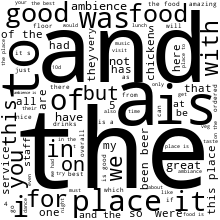

In [14]:
word_cloud_images['10 Downing Street']

In [15]:
def restaurant_term_frequencies(reviews_list):
    '''
    Calculates term frequencies from a list of reviews.
    Input: reviews_list (list of str): List of review texts
    Output: dataframe containing term frequencies
    '''
    # Convert the list of reviews into a DataFrame
    reviews_df = pd.DataFrame(reviews_list, columns=["Review"])

    # Vectorize the reviews to get trigrams
    trigram_bow_vectorizer = CountVectorizer(ngram_range=(1, 3), token_pattern=r"(?u)\b\w+\b")
    reviews_bow_td_matrix = trigram_bow_vectorizer.fit_transform(reviews_df["Review"]).toarray()
    reviews_bow_word_list = trigram_bow_vectorizer.get_feature_names_out()

    # Calculate word frequencies
    reviews_raw_vocabulary_df = p.word_freq_calculator(reviews_bow_td_matrix, reviews_bow_word_list, df_output=True)

    return reviews_raw_vocabulary_df

In [16]:
term_frequencies = {}

for name, reviews_list in reviews_per_restaurant.items():
    term_frequencies[name] = restaurant_term_frequencies(reviews_list)

# pipeline_v1e.plot_term_frequency(term_frequencies['10 Downing Street'], 20, "Term Frequencies from Reviews", show=True)

In [17]:
# Concatenate all DataFrames in the dictionary into a single DataFrame
combined_df = pd.concat(term_frequencies.values(), ignore_index=True)

# Group by 'words' and calculate the sum of 'frequency' for each unique word
result_df = combined_df.groupby('words', as_index=False)['frequency'].sum()

# Sort by frequency in descending order (optional, for better readability)
result_df = result_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)

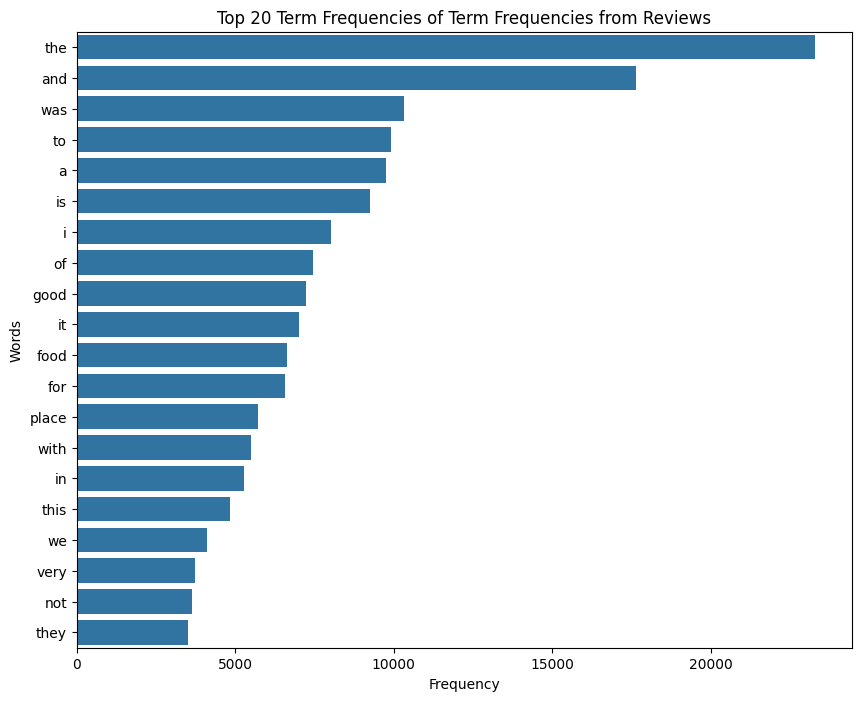

In [18]:
v.plot_term_frequency(result_df, 20, "Term Frequencies from Reviews", show=False)

Insights:
- The only non-stopwords in the combined top 20 tokens are "good", "food" and "place". The appearance of "good" in particular may indicate an overall positive polarity, however it is comm

## 4. Preprocessed Exploration

### 4.1. Preprocessing

In [19]:
reviews["Preproc_Review"] =\
      reviews["Review"].apply(lambda content :\
                                                  p.main_pipeline(content, 
                                                                  print_output=False,
                                                                  lemmatized=False,
                                                                  lowercase=True,
                                                                  tokenized_output=False))
                                                            

In [20]:
bow_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b")

In [21]:
reviews_bow_td_matrix = bow_vectorizer.fit_transform(reviews["Preproc_Review"]).toarray()
reviews["Review_bow_vector"] = reviews_bow_td_matrix.tolist()
reviews_bow_word_list = bow_vectorizer.get_feature_names_out()
reviews.head()

,Review,Rating,Cuisines,Cuisines_binary,Preproc_Review,Review_bow_vector
0,"The ambience was good, food was quite good . h...",5,"[Chinese, Continental, Kebab, European, South ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...",ambience good food quite good saturday lunch c...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Ambience is too good for a pleasant evening. S...,5,"[Chinese, Continental, Kebab, European, South ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...",ambience good pleasant evening service prompt ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,A must try.. great food great ambience. Thnx f...,5,"[Chinese, Continental, Kebab, European, South ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...",must try great food great ambience thnx servic...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Soumen das and Arun was a great guy. Only beca...,5,"[Chinese, Continental, Kebab, European, South ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...",soumen das arun great guy behavior sincerety g...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Food is good.we ordered Kodi drumsticks and ba...,5,"[Chinese, Continental, Kebab, European, South ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...",food ordered kodi drumsticks basket mutton bir...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 4.2. Term frequencies

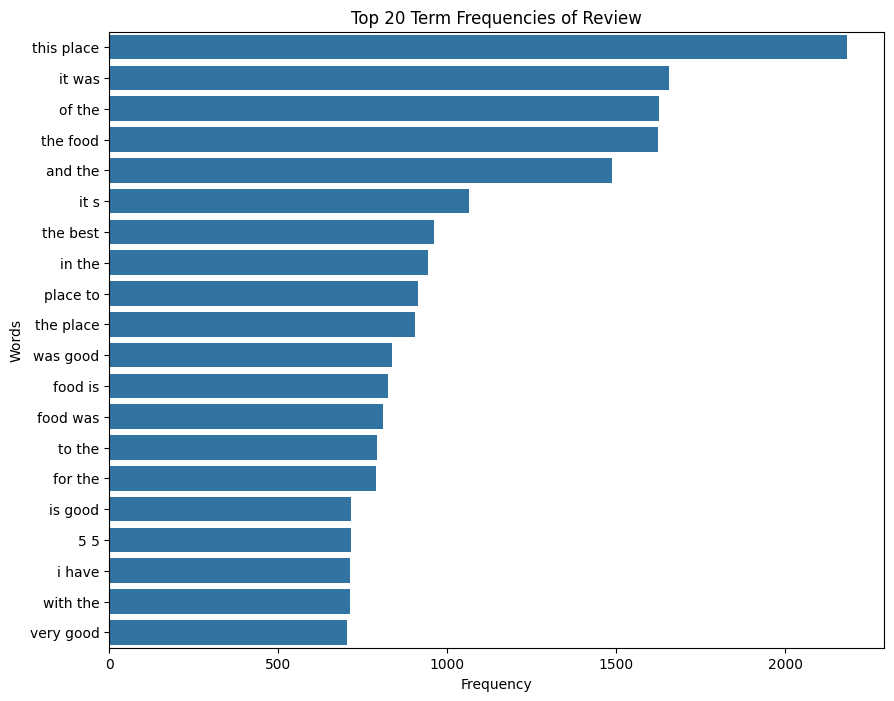

In [23]:
# Plot the 20 most common words by vectorising the raw content using bigram BoW

bigram_bow_vectorizer = CountVectorizer(ngram_range=(2,2), token_pattern=r"(?u)\b\w+\b")  

reviews_bow_td_matrix = bigram_bow_vectorizer.fit_transform(reviews["Review"]).toarray()
reviews_bow_word_list = bigram_bow_vectorizer.get_feature_names_out()

reviews_raw_vocabulary_df = p.word_freq_calculator(reviews_bow_td_matrix,\
                                                                      reviews_bow_word_list, df_output=True)
v.plot_term_frequency(reviews_raw_vocabulary_df, 20, "Review", show=False)

## 5. Class Exploration - Cuisines

### 5.1. Class Balance

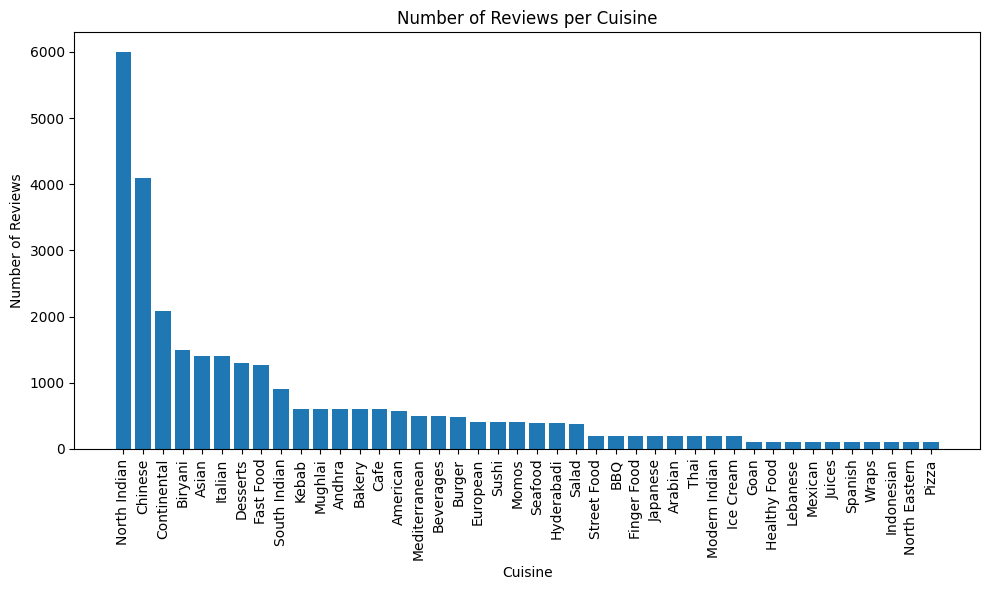

In [33]:
# Count the number of reviews per cuisine
cuisine_counts = {}
for cuisines in reviews['Cuisines']:
    for cuisine in cuisines:
        if cuisine in cuisine_counts:
            cuisine_counts[cuisine] += 1
        else:
            cuisine_counts[cuisine] = 1

# Sort the cuisines by number of reviews in decreasing order
sorted_cuisine_counts = dict(sorted(cuisine_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the sorted data
plt.figure(figsize=(10, 6))
plt.bar(sorted_cuisine_counts.keys(), sorted_cuisine_counts.values())
plt.xlabel('Cuisine')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Cuisine')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 5.2. Word Visualizations per Cuisine

In [ ]:
# Flatten the list of cuisines and get unique cuisine names
unique_cuisines = set(cuisine for cuisines in reviews['Cuisines'] for cuisine in cuisines)

In [35]:
# Creates a corpus of documents, each with the concatenated reviews of a cuisine
corpus = []
for label in unique_cuisines:
    label_doc = ""
    for review in reviews["Preproc_Review"].loc[reviews["Cuisines"].apply(lambda x: label in x)]:
        label_doc = label_doc + " " + review
    corpus.append(label_doc)

print("Length of unique_cuisines: {}; Length of corpus: {}".format(len(unique_cuisines), len(corpus)))

Length of unique_cuisines: 42; Length of corpus: 42


In [37]:
# Vectorizing the corpus and plo
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b")  
wc = WordCloud(background_color="white",max_words=120, width = 220,height = 220, color_func=lambda *args, **kwargs: (0,0,0))

In [41]:
# Generate word clouds for each genre label from the TF-IDF vectorisation of the corpus, storing the results in the "word_clouds" folder 
folder_path = "../data_exploration/visualizations/word_clouds"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for idx, document in enumerate(corpus):
    cuisines_tfidf_td_matrix = bigram_tfidf_vectorizer.fit_transform(corpus)
    cuisines_tfidf_word_list = bigram_tfidf_vectorizer.get_feature_names_out()

    cuisines_corpus_vocabulary = p.word_freq_calculator(cuisines_tfidf_td_matrix[idx].toarray(),\
                                                                        cuisines_tfidf_word_list, df_output=False)
    wc.generate_from_frequencies(cuisines_corpus_vocabulary)
    wc.to_file(os.path.join(folder_path, "WC_"+list(unique_cuisines)[idx]+"TFIDF.png"))

In [22]:
# Folder for saving review visualizations
folder_path = '../data_exploration/visualizations/word_counts'
if not os.path.exists(folder_path):
    # Create the folder if it doesn't yet exist
    os.makedirs(folder_path)

for cuisine_name in unique_cuisines:
    # Filter reviews for this cuisine
    cuisine_reviews = reviews[reviews['Cuisines'].apply(lambda x: cuisine_name in x)]
    
    # Aggregate the BoW vectors for the cuisine
    if len(cuisine_reviews) > 0:
        cuisine_bow_vector_sum = np.sum(np.array(cuisine_reviews['Review_bow_vector'].tolist()), axis=0)
        cuisine_bow_df = p.word_freq_calculator([cuisine_bow_vector_sum], reviews_bow_word_list)
        
        # Plot and save the BoW visualization
        cuisine_bow_plot = v.plot_term_frequency(
            cuisine_bow_df, 20,
            f"{cuisine_name} Cuisine - 20 Most Common Words (BoW)",
            show=False
        )
        # Commented to avoid filling the folder again
        #cuisine_bow_plot.savefig(os.path.join(folder_path, f"{cuisine_name}_BOW.png"))
        
print(f"Saved BoW and TF-IDF visualizations for each cuisine in '{folder_path}'.")

Saved BoW and TF-IDF visualizations for each cuisine in '../data_exploration/visualizations'.


## 6. Main Insights

- **Null rows** - There are 45 rows with empty reviews. We dropped these, consideing they made up less than 0.5% of data.
- **Sentence structure** - Review length varies between 1 and 5212 characters, the avergae being 280 characters. It is noteworthy that the 75th percentile is of 321 charcaters, this may indicate some outliers (exceptionally long reviews). In terms of sentences, the reviews have between 1 and 66 sentences, average of 4, with the same issue of the 75th percentile being 5, pssibly showing outliers. This is more clearly seen in the graphs, where the vast majority of reviews tend to be smaller and with less sentences.
- **Class balance** - There is clear class imbalance in the datatset. North Indian is by far the most common cuisine, with Chinese at second place. The most under-represented cuisines are Goan, Healthy Food, Lebanese, Mexican, Juices, Spanish, Wraps, Pizza, and North Eastern. This makes sense due to the geolocation of the restaurants in question. We should expect good performance from the model in the North Indian and Chinese cuisines, and will try to optiize considering this imbalance by using weighted measures.
- **Word occurence** - In the top 20, the only non-stopwords present are "good", "food", "place" and "very". This makes sense, given the reviews are often talking about the restaurant's food, and that not only the good, but also the bad reviews include "good" (as in not good) and "very" (as in very bad)
- **Class uniqueness** - Upon analysing the word clouds, we can see that some cuisiens will be easier to identify due to having unique words. This is the case of Bakery, Beverages, Cafe, Desserts, Ice Cream (very identifiable), North Eastern and Wraps. On the other hand, we can expect worse performance on the cuisines that are less unique, like Adhra, Asian, BBQ, Chinese, Italian or Kebab, among others.